Grid World

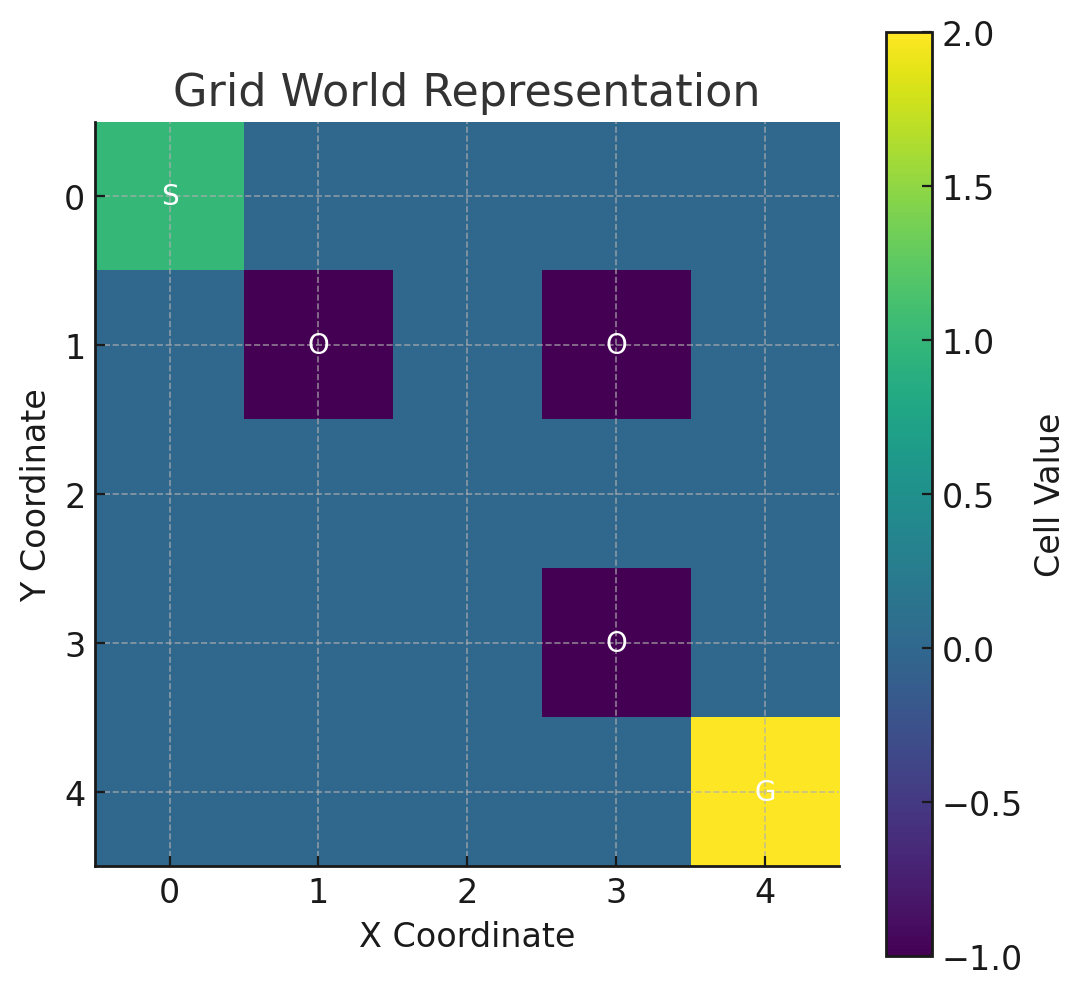

In [1]:
import numpy as np

class GridWorld:
    def __init__(self):
        self.grid_size = 5
        self.obstacles = [(1, 1), (1, 3), (3, 3)]  # Obstacle positions
        self.start = (0, 0)  # Starting position
        self.goal = (4, 4)  # Goal position
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        # Define possible actions
        actions = {'left': (0, -1), 'right': (0, 1), 'up': (-1, 0), 'down': (1, 0)}
        next_state = tuple(np.array(self.state) + np.array(actions[action]))

        # Check if the new state is valid
        if 0 <= next_state[0] < self.grid_size and 0 <= next_state[1] < self.grid_size and next_state not in self.obstacles:
            self.state = next_state

        #reward = -1  # Default reward
        done = self.state == self.goal  # Check if goal is reached

        # Assign different rewards based on the cell type
        if done:
            reward = 5  # Reward for reaching the goal
        elif next_state in self.obstacles:
            reward = -3  # Penalty for moving into an obstacle
        else:
            reward = -1  # No penalty for moving to an empty cell

        return self.state, reward, done

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for obs in self.obstacles:
            grid[obs] = -1  # Mark obstacles
        grid[self.start] = 0.5  # Mark start
        grid[self.goal] = 2  # Mark goal
        grid[self.state] = 1  # Mark current state
        print(grid)


In [2]:
pip install torch torchvision


Architecture of Actor and Critic

Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900


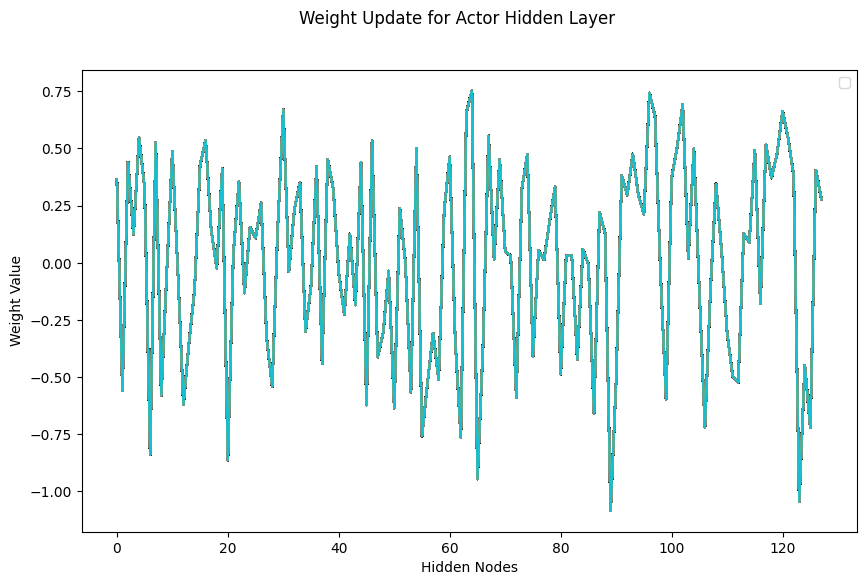

Win Rate: 100.00%


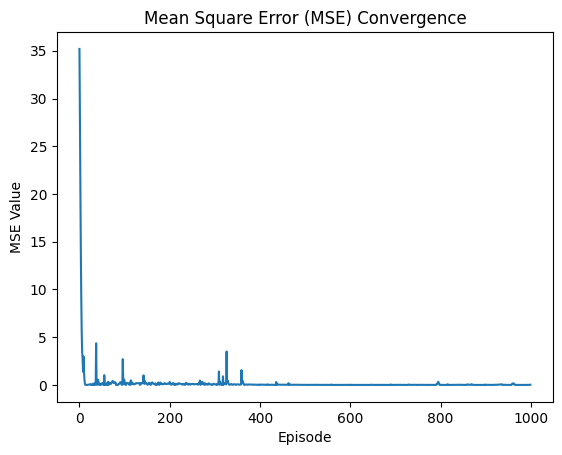

Final Q-table:
[[[8.14676168e-05 1.35420574e-04 3.36189223e-05 9.99749482e-01]
  [4.46585473e-05 1.93867763e-05 4.04393977e-05 9.99895453e-01]
  [6.03283588e-05 5.34366758e-04 5.78798281e-05 9.99347389e-01]
  [1.08396729e-04 5.35583943e-02 9.88502652e-05 9.46234345e-01]
  [1.60925883e-05 9.62060869e-01 1.30079388e-05 3.79100852e-02]]

 [[7.67044583e-03 1.44481078e-01 1.10792916e-03 8.46740544e-01]
  [6.44784700e-03 5.42099215e-02 2.36623036e-03 9.36975956e-01]
  [4.56739543e-03 4.11796838e-01 2.59865518e-03 5.81037104e-01]
  [1.86940364e-04 9.87556040e-01 1.03087848e-04 1.21539133e-02]
  [2.18253172e-06 9.99932885e-01 1.07233541e-06 6.39404243e-05]]

 [[1.04064262e-03 5.24954461e-02 7.09371379e-05 9.46393013e-01]
  [1.33494625e-03 4.71385270e-02 2.40304173e-04 9.51286197e-01]
  [1.63183338e-03 4.42344785e-01 5.23446070e-04 5.55499971e-01]
  [8.97494974e-05 9.88502383e-01 3.90391106e-05 1.13688391e-02]
  [1.04744038e-06 9.99960065e-01 4.04286652e-07 3.85626299e-05]]

 [[5.01590985e-05 6

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

# Neural Network for the Actor
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        action_probs = F.softmax(self.fc2(x), dim=-1)
        return action_probs

# Neural Network for the Critic
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        state_value = self.fc2(x)
        return state_value

# Actor-Critic Agent
class ActorCriticAgent:
    def __init__(self, input_dim, output_dim, lr_actor=0.001, lr_critic=0.001):
        self.actor = Actor(input_dim, output_dim)
        self.critic = Critic(input_dim)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.weights_history = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float)
        action_probs = self.actor(state)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def learn(self, state, reward, next_state, done, actions):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        action = torch.tensor(actions, dtype=torch.long)

        # Critic loss
        value = self.critic(state)
        next_value = self.critic(next_state)
        td_target = reward + 0.9 * next_value * (1 - int(done))
        td_error = td_target - value

        critic_loss = td_error**2

        # Actor loss
        action_probs = self.actor(state)
        dist = torch.distributions.Categorical(action_probs)
        actor_loss = -dist.log_prob(action) * td_error.detach()

        # Backpropagation
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        self.optimizer_actor.step()
        self.optimizer_critic.step()

        return critic_loss.item()
    def get_specific_weight(self):
        # Replace 'weight_index' with the index of the weight you want to track
        return self.actor.fc1.weight.data[0, 0].item()

    def get_actor_hidden_weight(self, node_index):
        return self.actor.fc1.weight[:, node_index].detach().numpy()

    def plot_actor_hidden_weight(self, hidden_weight_history):
        fig, ax = plt.subplots(figsize=(10, 6))
        fig.suptitle('Weight Update for Actor Hidden Layer')

        for episode, weights in enumerate(hidden_weight_history):
            ax.plot(weights)

        ax.set_xlabel('Hidden Nodes')
        ax.set_ylabel('Weight Value')
        ax.legend()
        plt.show()
# Main Training Loop
def train():
    num_episodes = 1000
    input_dim = 2  # Since the state is represented by a 2D position
    output_dim = 4  # 4 possible actions: up, down, left, right

    env = GridWorld()
    agent = ActorCriticAgent(input_dim, output_dim)
    weight_index = 2
    weight_values = []
    hidden_weight_history = []


    mse_values = []
    #win_rates = []
    success_count = 0


    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_rewards = 0
        while not done:
            action = agent.select_action(state)
            actions = {'0': 'up', '1': 'down', '2': 'left', '3': 'right'}
            next_state, reward, done = env.step(actions[str(action)])

            # Track the value of the specific weight during training
            specific_weight = agent.get_specific_weight()
            weight_values.append(specific_weight)

            agent.learn(state, reward, next_state, done, action)
            state = next_state

            episode_rewards += reward
        hidden_weight = agent.get_actor_hidden_weight(node_index=0)  # Replace 0 with the desired node index
        hidden_weight_history.append(hidden_weight)

        if episode % 100 == 0:
            print(f"Episode: {episode}")

        if env.state == env.goal:  # Check if the goal is reached
            success_count += 1
        # Calculate and log mean square error
        mse_values.append(agent.learn(state, reward, next_state, done, action))

    agent.plot_actor_hidden_weight(hidden_weight_history)
    win_rate = success_count / num_episodes
    print(f"Win Rate: {win_rate:.2%}")


    # Plot MSE values
    plt.plot(mse_values)
    plt.title('Mean Square Error (MSE) Convergence')
    plt.xlabel('Episode')
    plt.ylabel('MSE Value')
    plt.show()



    # Print final Q-table and value table
    q_table = np.zeros((env.grid_size, env.grid_size, output_dim))
    v_table = np.zeros((env.grid_size, env.grid_size))

    for i in range(env.grid_size):
        for j in range(env.grid_size):
            state = (i, j)
            state_tensor = torch.tensor(state, dtype=torch.float)
            q_values = agent.actor(state_tensor).detach().numpy()
            v_values = agent.critic(state_tensor).item()

            q_table[i, j, :] = q_values
            v_table[i, j] = v_values

    print("Final Q-table:")
    print(q_table)

    print("\nFinal Value Table:")
    np.set_printoptions(precision=2, suppress=True)
    print(v_table)



if __name__ == "__main__":
    train()
